In [121]:
import astropy.units as u
from astroquery.xmatch import XMatch
from astropy.table import Column,QTable
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
from astroquery.xmatch import XMatch
import numpy as np
import pandas as pd
from astropy.io import ascii

coord = SkyCoord("04:30:47.99", "+64:50:56.5", unit=(u.hourangle, u.deg), frame='icrs')
rad = 6 * u.arcminute

catalogs = ['vizier:I/350/gaiaedr3', 'vizier:II/246/out', 'vizier:II/328/allwise', 'vizier:II/349/ps1']

data = pd.DataFrame()
df_gaia = QTable(names=('RA_ICRS','DE_ICRS'))
data_2mass = QTable()
data_wise = QTable()
data_panstarrs = QTable()

df_gaia = QTable(names=('RA_ICRS', 'DE_ICRS', 'Gmag'))
df_2mass = QTable(names=('RAJ2000', 'DEJ2000', 'Jmag', 'Hmag', 'Kmag'))
df_wise = QTable(names=('RAJ2000', 'DEJ2000', 'W1mag', 'W2mag', 'W3mag', 'W4mag'))
df_panstarrs = QTable(names=('RAJ2000', 'DEJ2000', 'gmag', 'rmag'))

result_table = Vizier.query_region(coord, radius=rad, catalog='I/350/gaiaedr3')
df_gaia = result_table[0]['RA_ICRS','DE_ICRS', 'Gmag', 'e_Gmag']

       
data_2mass = XMatch.query(cat1=df_gaia,
                     cat2=catalogs[1],
                     max_distance=3*u.arcsec,
                     colRA1='RA_ICRS', colDec1='DE_ICRS')

data_wise = XMatch.query(cat1=data_2mass,
                     cat2=catalogs[2],
                     max_distance=3*u.arcsec,
                     colRA1='RA_ICRS', colDec1='DE_ICRS')

data_panstarrs = XMatch.query(cat1=data_wise,
                     cat2=catalogs[3],
                     max_distance=3*u.arcsec,
                     colRA1='RA_ICRS', colDec1='DE_ICRS')

mag = [['Gmag', 'e_Gmag'], ['Jmag_2', 'e_Jmag_2'],['Hmag_2', 'e_Hmag_2'], ['Kmag_2', 'e_Kmag_2'],
       ['W1mag', 'e_W1mag'], ['W2mag', 'e_W2mag'], ['W3mag', 'e_W3mag'], ['W4mag', 'e_W4mag'],
       ['gmag', 'e_gmag'], ['rmag', 'e_rmag'], ['imag', 'e_imag'], ['zmag', 'e_zmag'], ['ymag', 'e_ymag']]

name = [['G_flux', 'e_G_flux', 'G_wl'],
         ['J_flux', 'e_J_flux', 'J_wl'],
         ['H_flux', 'e_H_flux', 'H_wl'],
         ['K_flux', 'e_K_flux', 'K_wl'],
         ['W1_flux', 'e_W1_flux', 'W1_wl'],
         ['W2_flux', 'e_W2_flux', 'W2_wl'],
         ['W3_flux', 'e_W3_flux', 'W3_wl'],
         ['W4_flux', 'e_W4_flux', 'W4_wl'],
         ['g_flux', 'e_g_flux', 'g_wl'],
         ['r_flux', 'e_r_flux', 'r_wl'],
         ['i_flux', 'e_i_flux', 'i_wl'],
         ['z_flux', 'e_z_flux', 'z_wl'],
         ['y_flux', 'e_y_flux', 'y_wl']]

ZP = [3229, 1594, 1024, 666.7, 309.54, 171.79, 31.676, 8.3635, 3964.03, 3173.02, 2575.36, 2261.81, 2180.4]
wl = [690, 1235, 1662, 2159, 3368, 4618, 12082, 22194, 481, 617, 752, 866, 962]

data['RA_ICRS'] = data_panstarrs['RA_ICRS']
data['DE_ICRS'] = data_panstarrs['DE_ICRS']

for i in range(len(ZP)):
    for j in range(2):
        data[mag[i][j]] = data_panstarrs[mag[i][j]]
data.fillna(0., inplace=True)

for i in range(len(name)):
    data[name[i][0]] = ZP[i]*10**(-0.4*data[mag[i][0]])
    data[name[i][1]] = data[mag[i][1]]*0.4*ZP[i]**10**(-0.4*(data[mag[i][0]] - 1))
    data[name[i][2]] = wl[i]*len(ZP)


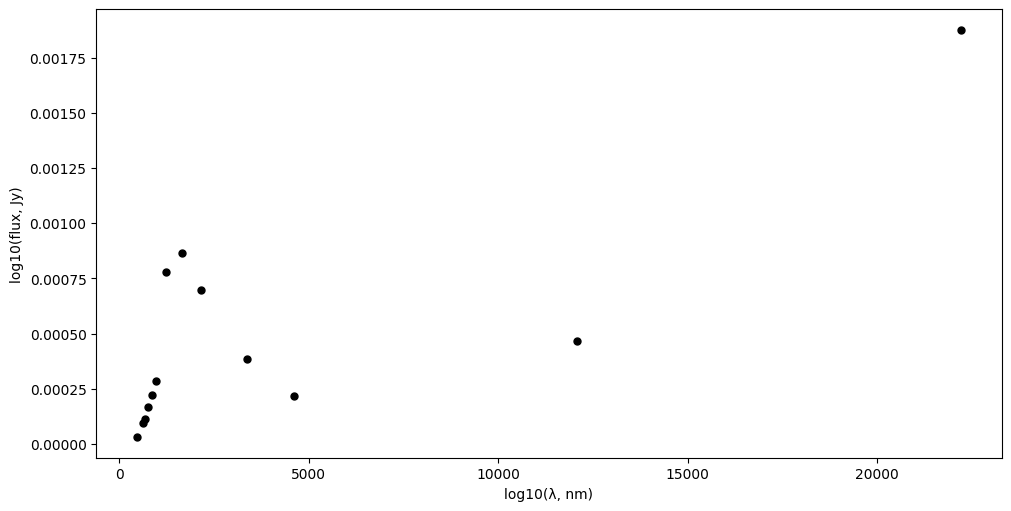

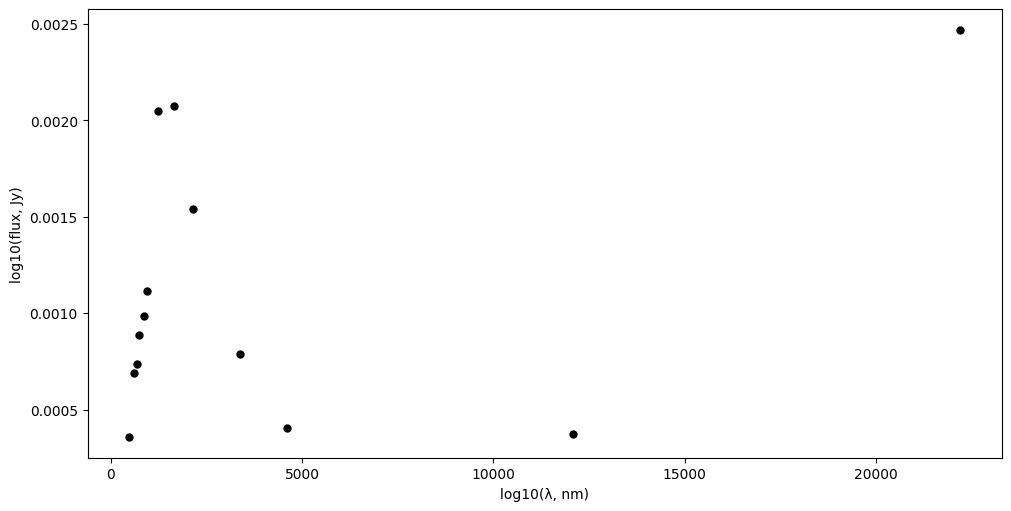

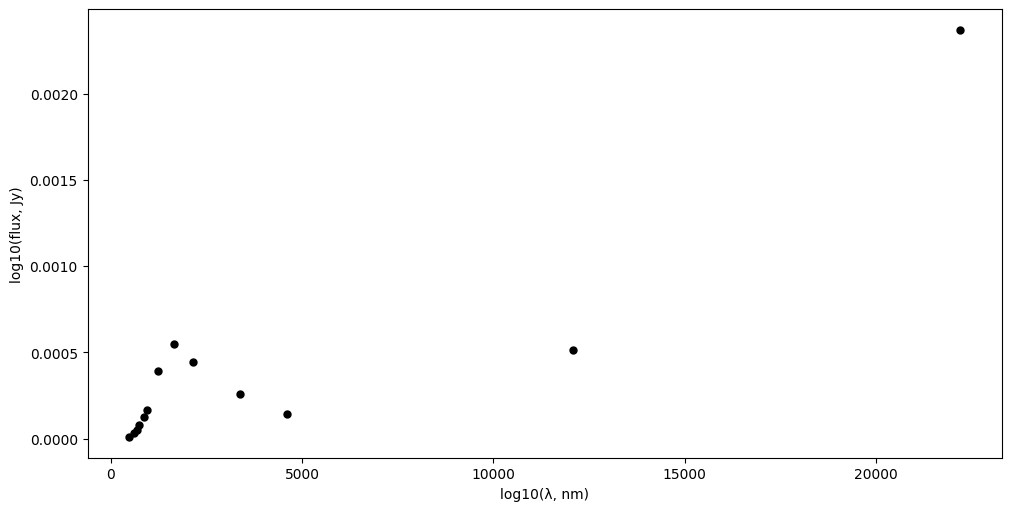

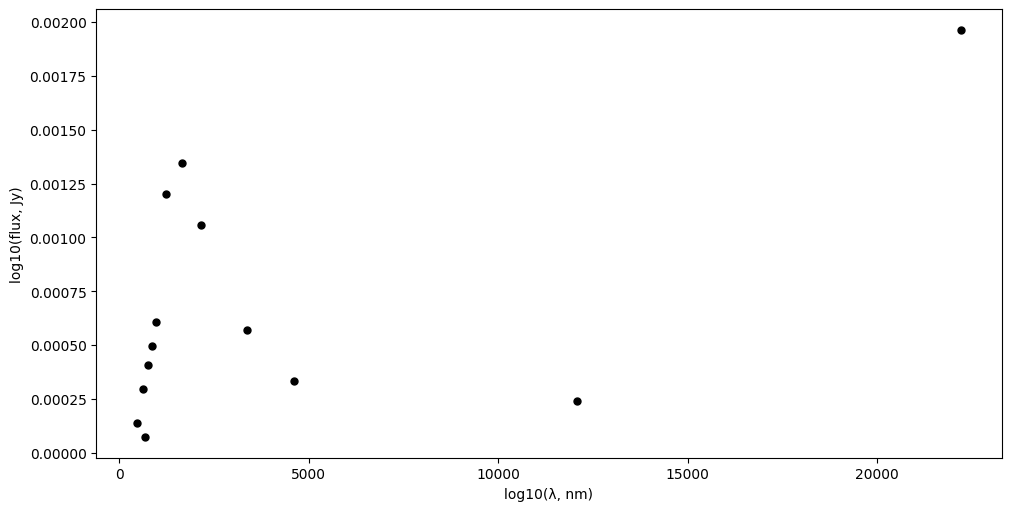

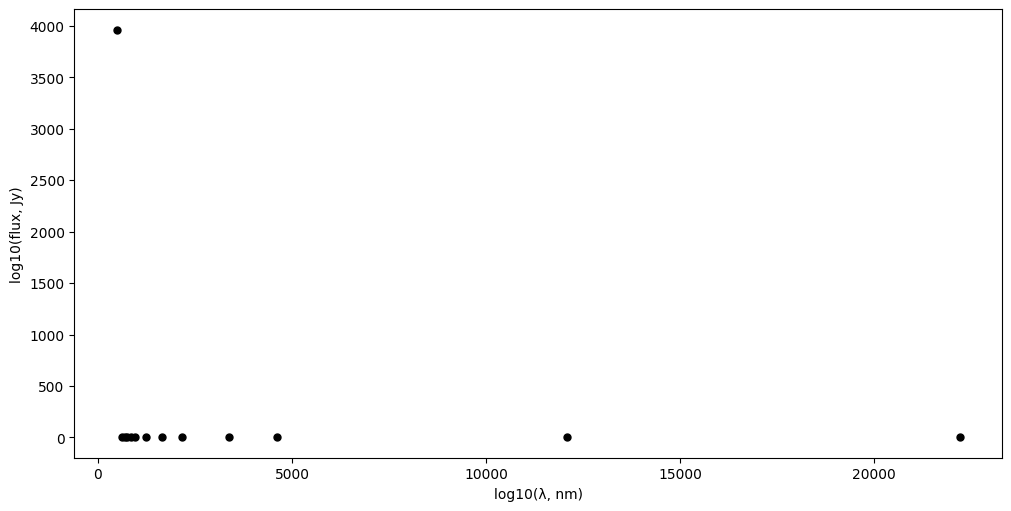

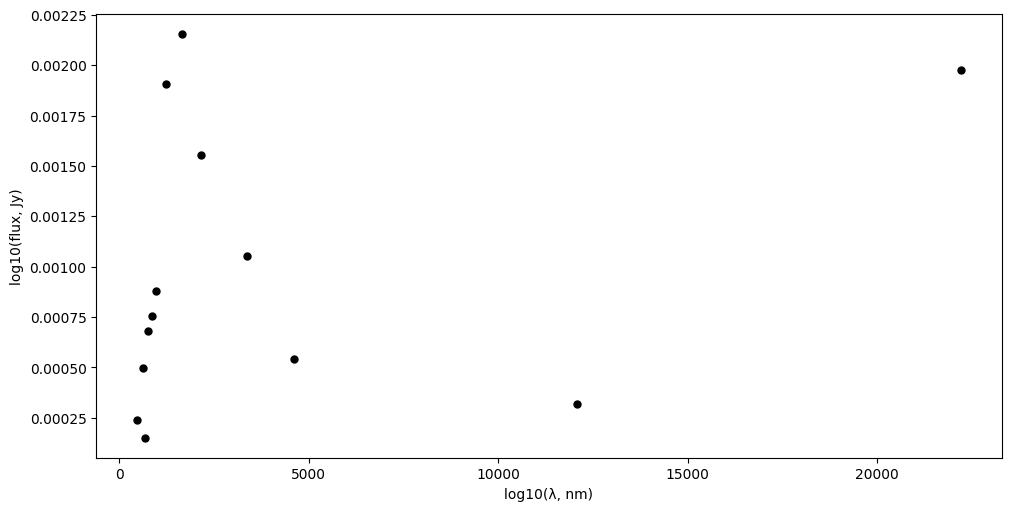

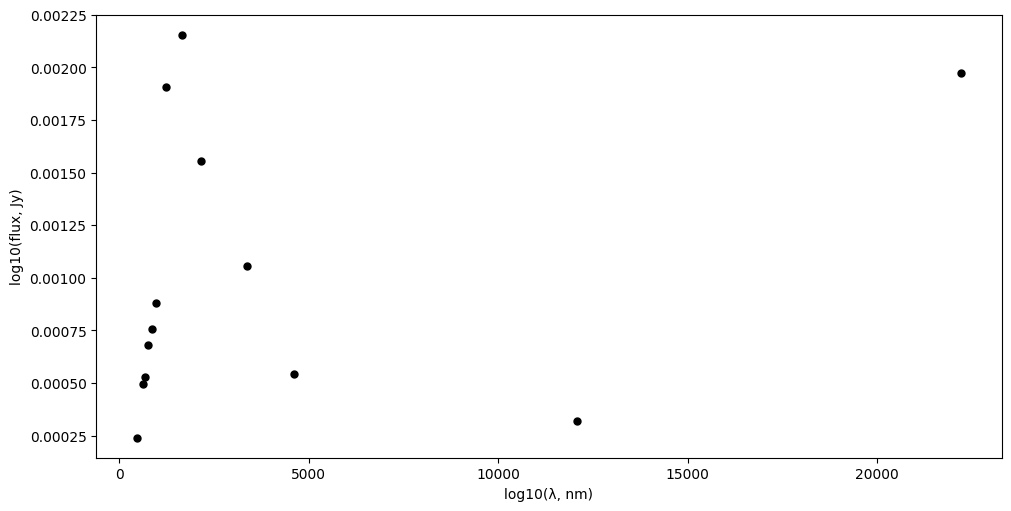

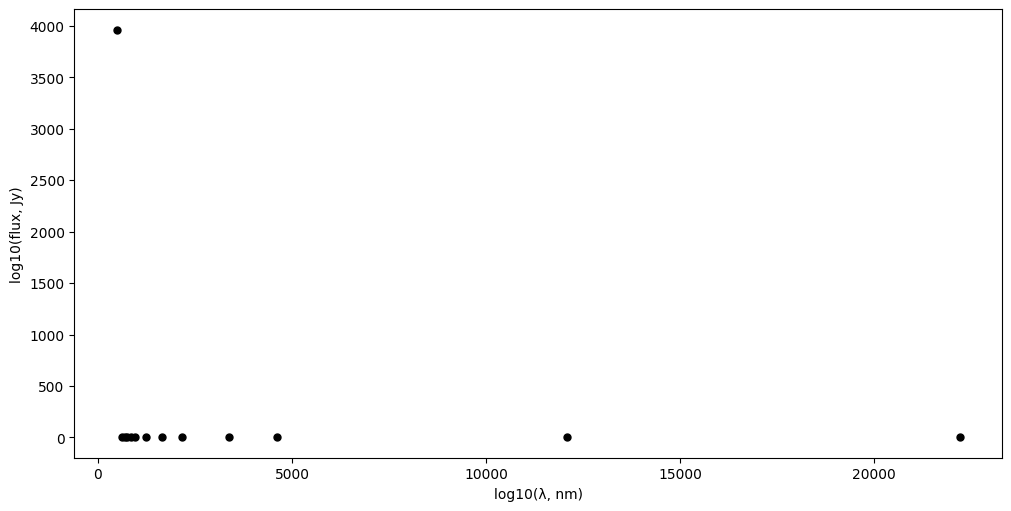

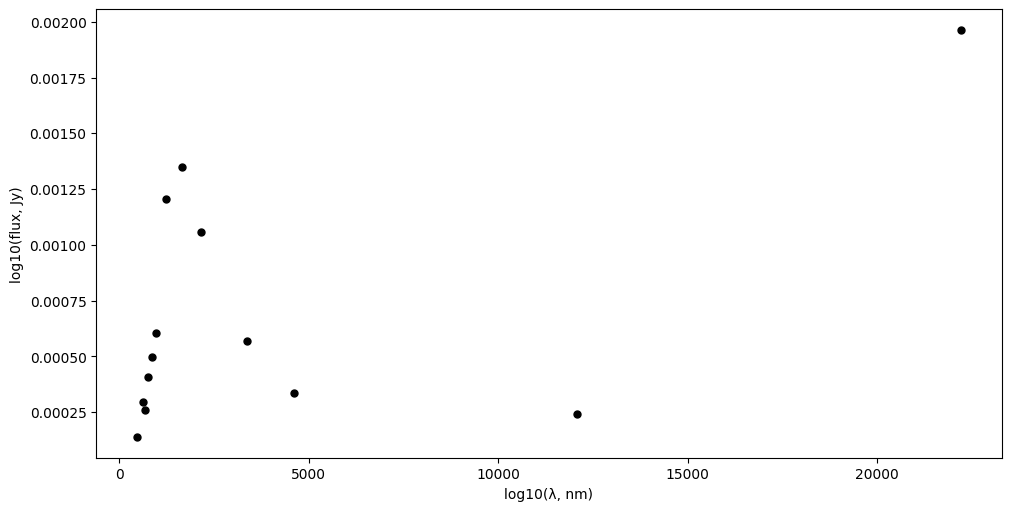

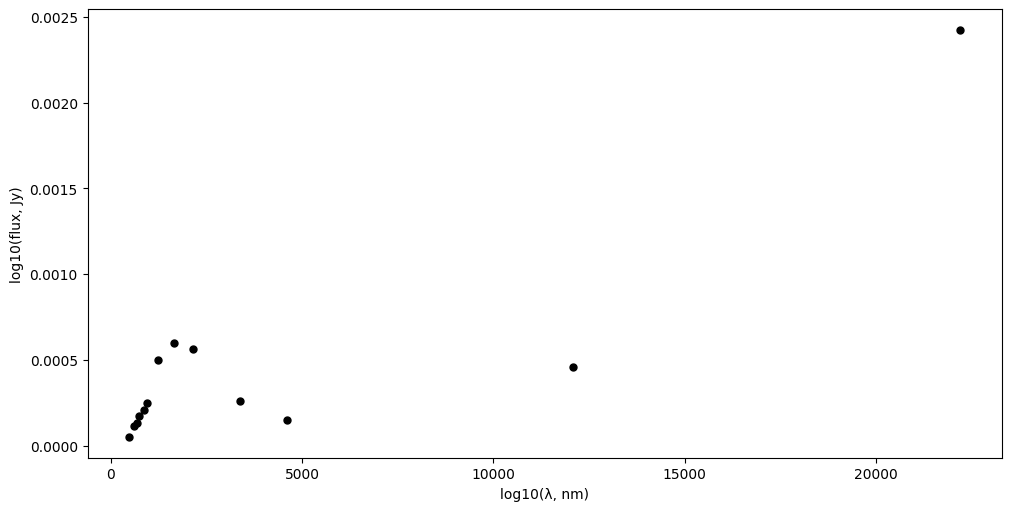

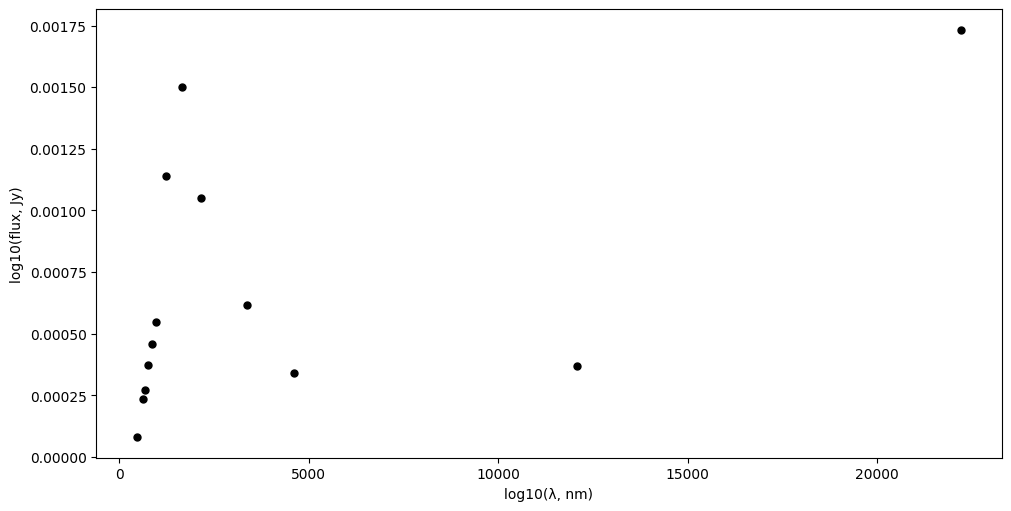

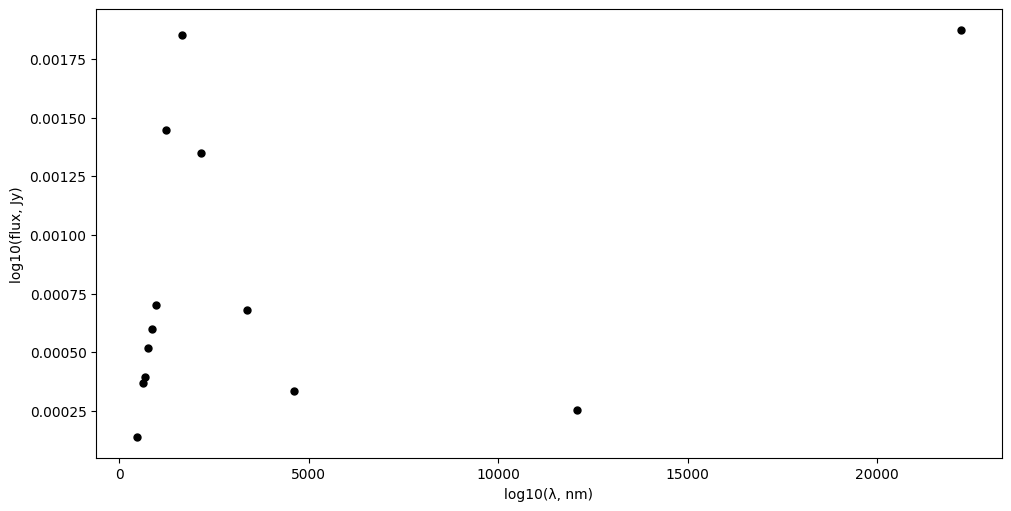

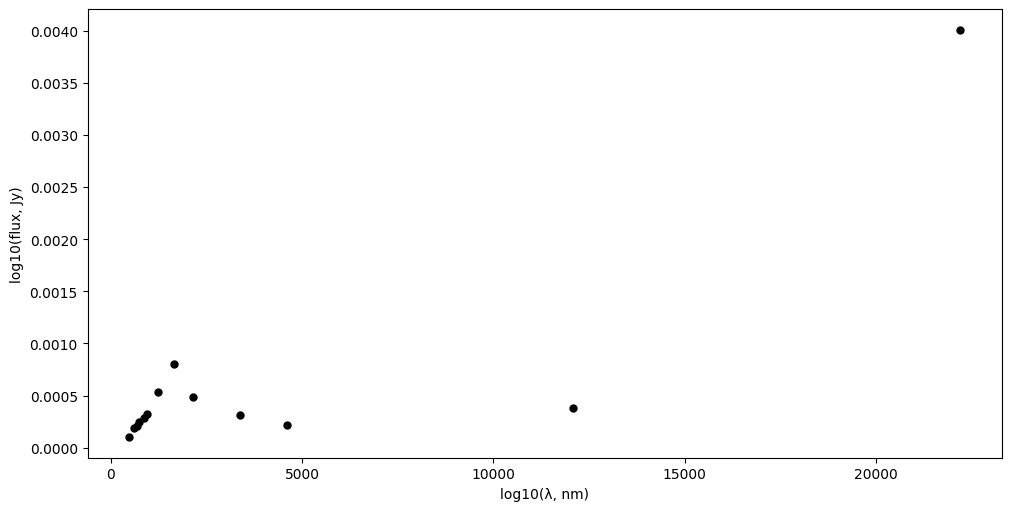

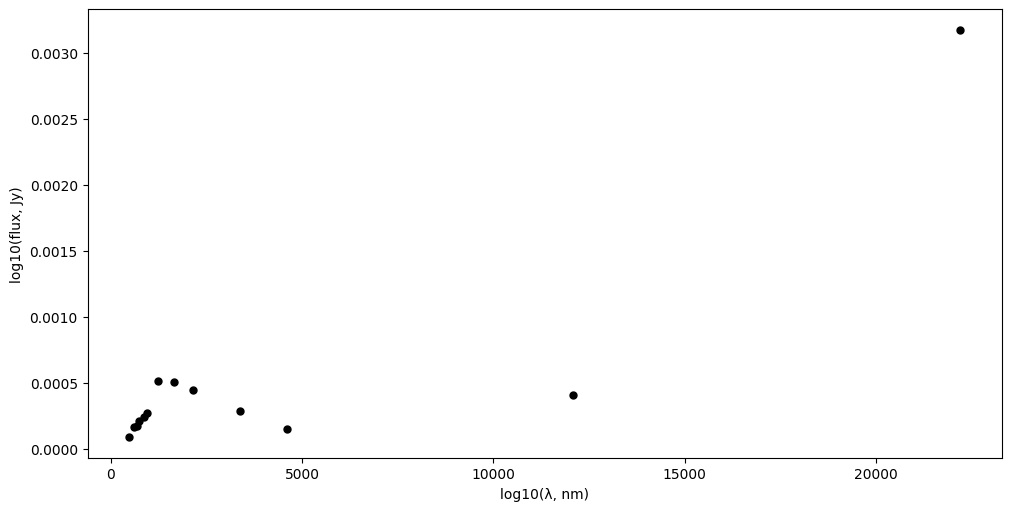

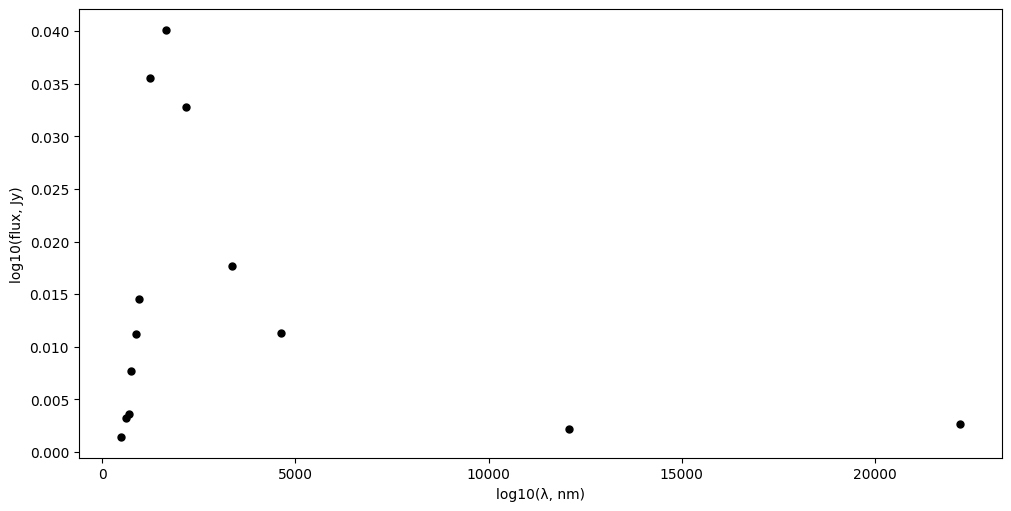

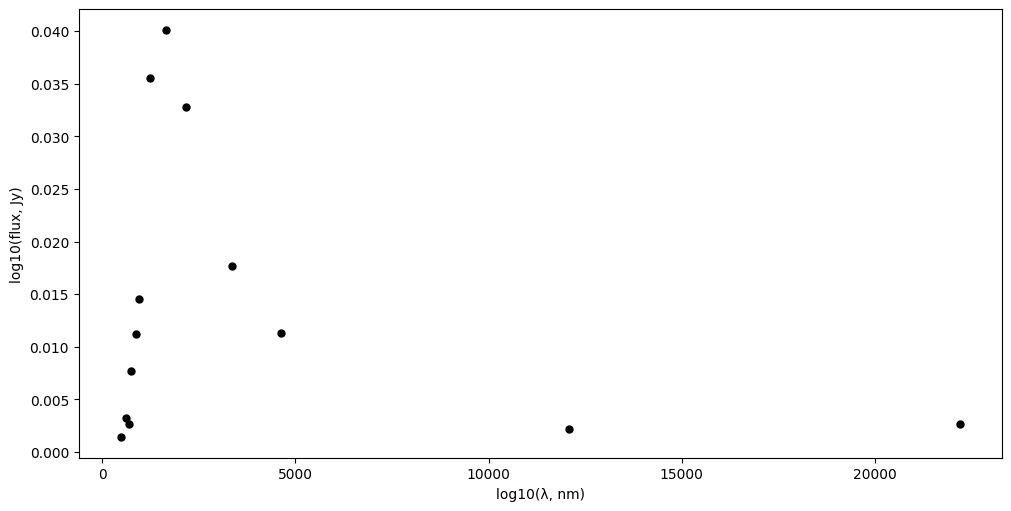

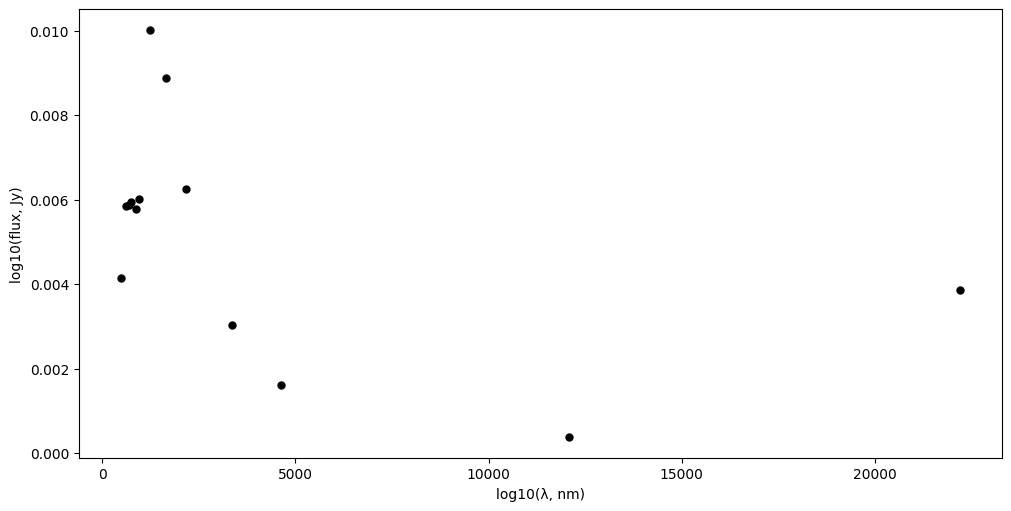

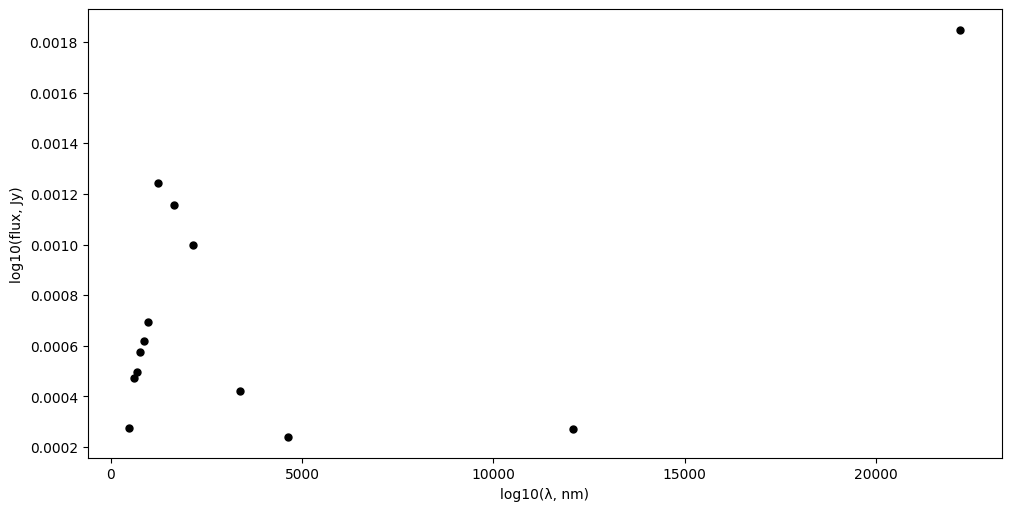

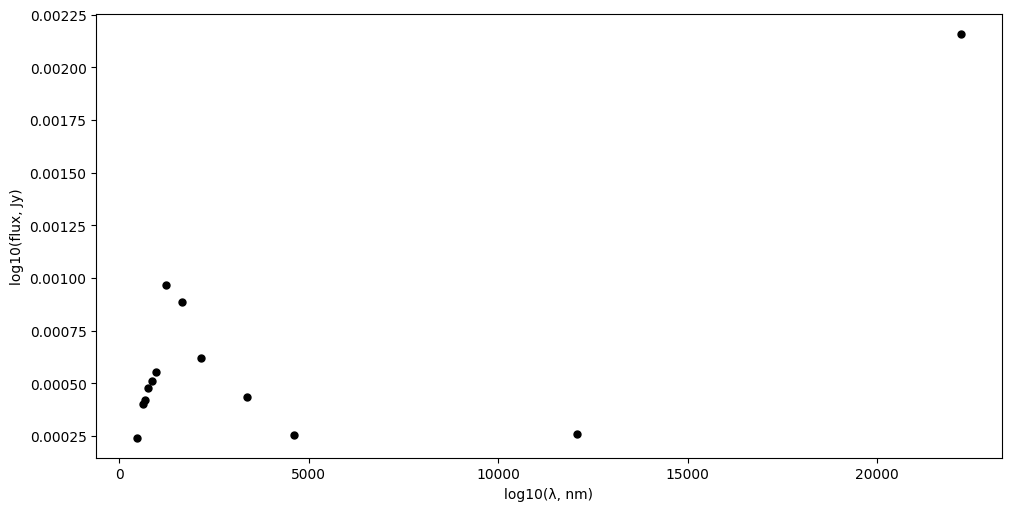

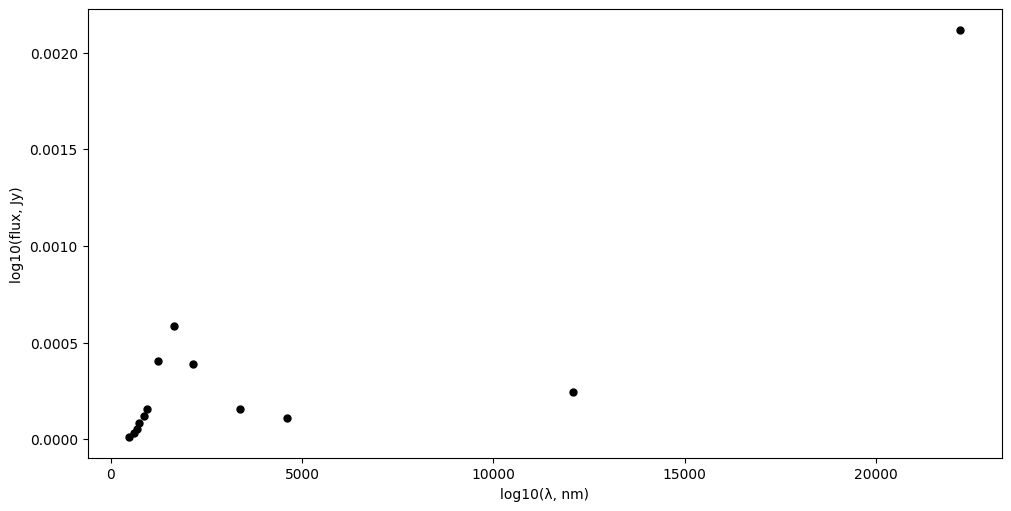

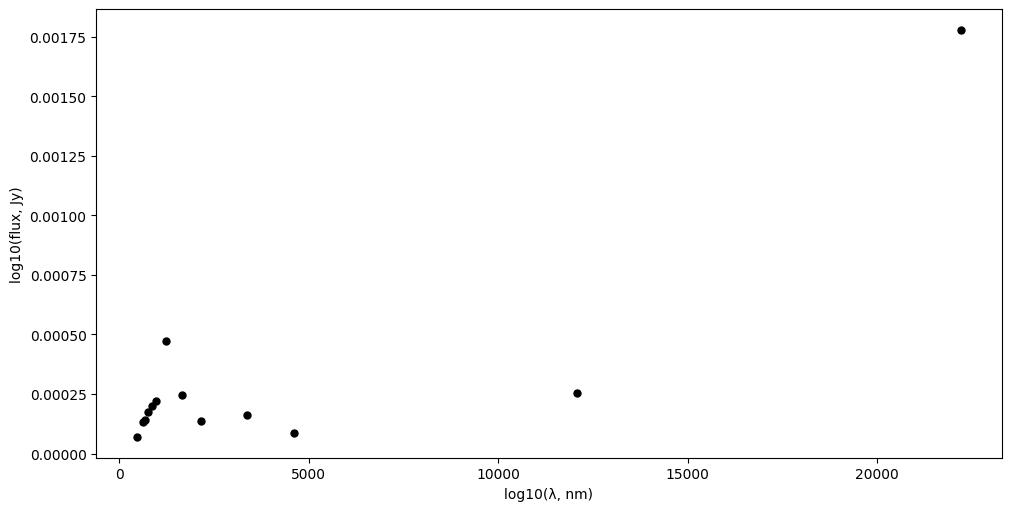

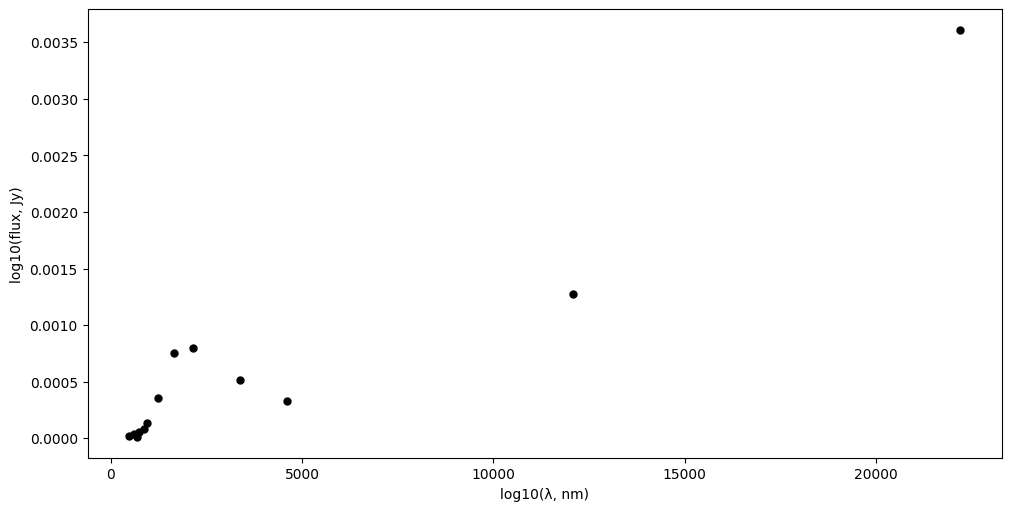

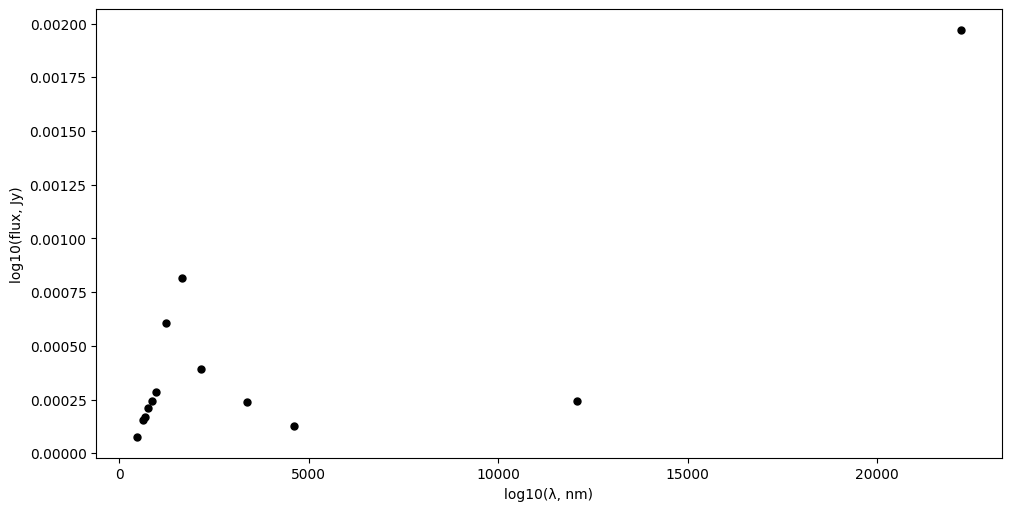

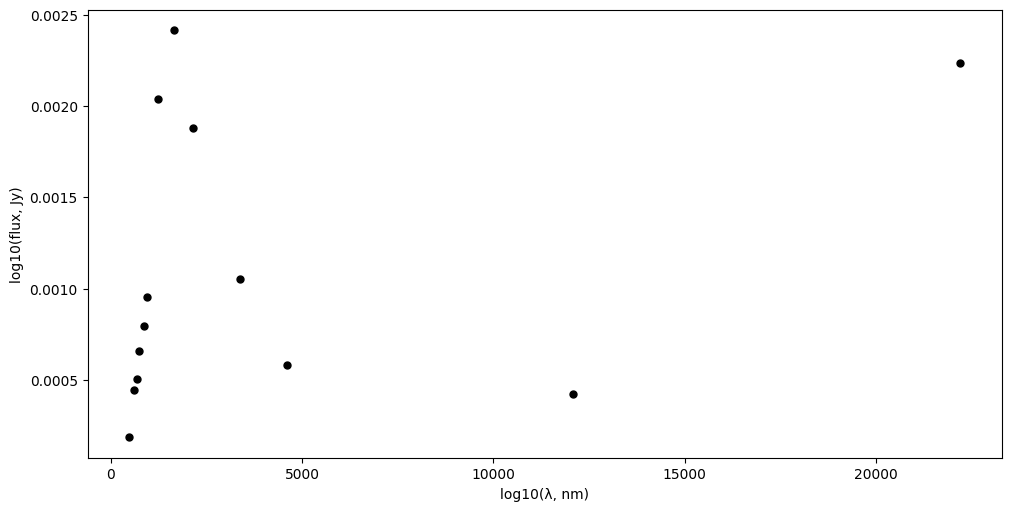

In [127]:
for i in range(len(data)):
    wave_length = [wl[i] for i in range(len(wl))]
    flux = [data[name[j][0]][i] for j in range(len(wl))]
    flux_error = [data[name[j][1]][i] for j in range(len(wl))]
    fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
    ax.scatter(wave_length, flux, color='black', s=25)
    #ax.errorbar(wave_length, flux, yerr=flux_error, fmt="o")
    ax.set_xlabel('log10(λ, nm)')
    ax.set_ylabel('log10(flux, Jy)')
    plt.show()